# Statistical Rethinking: Chapter 6 Practice Answers

We use some of the code from [the pymc-devs Python/pymc3 port of the Statistical Rethinking code examples](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/).

### 6E1

Three mechanisms by which multiple regression can produce false inferences about causal effects are:
- multicollinearity
- post-treatment bias
- collider bias

### 6E2

Examples of each:
- **multicollinearity**: considering the dataset on [strength-to-weight ratios in climbing](https://static1.squarespace.com/static/56830ef60ab377cb562da204/t/5f99cebdafb139471fbafd67/1603915468772/BF_strength_climbing_correlations-MAR282018web.pdf), left-hand strength [strongly influences bouldering grade](https://oadams.github.io/statistical_rethinking_solutions/ch5.html), and right-hand strength probably does too. If we were to include them both in a multiple regression model as predictors of climbing grade, we might suffer from multicollinearity. This is because multiple regression will tell us the effect each predictor has on the outcome after fixing the other predictors.
- **post-treatment bias**: Continuing on the climbing theme, perhaps we could consider protein or creatine consumption as predictors of bouldering grade. If we lumped hand strength in as a predictor along with supplement consumption our inference might show no relationship between supplement consumption and climbing grade. This is because we expect the supplement gains to be mediated by increases in hand strength. Visually, our DAG is `supp -> strength -> grade`. Including `strength` as a predictor blocks the causal flow from `supp` to `grade`. (In practice it's probably more complicated since your supplements affect leg strength too, which will affect climbing ability. If `strength` instead represented a holistic measure of strength, then the post-treatment bias would be pure).
- **collider bias**: This one may or may not be valid, since there are a lot of other variables, but it comes to mind: salary and physical attractiveness of a prospective partner. Salary and physical attractiveness may be uncorrelated, but they both affect the overall attractiveness ('value') of a romantic partner (if not to you, then to their other prospective partners). This is a V, structure represented as `salary -> value <- appearance`. Since the partners available to you are determined by their value (relative to your value), you are observing this variable and that induces a negative correlation between `salary` and `appearance`. This is a case of Berkson's paradox, which is a specific case of collider bias. While there may be no correlation between salary and physical attractiveness, candidates that are very high in both categories may be 'out of your league' inducing a negative correlation in the remaining sample.

### 6E3

The four elemental confounds:
- **The Fork**, $X \leftarrow Z \rightarrow Y$. The conditional independence $X \perp Y | Z$: observing $Z$ blocks the flow from $X$ to $Y$.
- **The Pipe**, $X \rightarrow Y \rightarrow Z$. The conditional independence is $X \perp Z | Y$ (observing $Y$ blocks the flow from $X$ to $Z$).
- **The Collider**, $X \rightarrow Z \leftarrow Y$. The conditional independence between $X$ and $Y$ holds true if $Z$ isn't observed directly or indirectly.
- **The Descendant** $X \rightarrow Z \leftarrow Y$ and additionally $Z \rightarrow D$. In this case observation of $D$ can similarly remove the independency between $X$ and $Y$ since it tells us something about $Z$.

### 6E4

A biased sample is like a collider because the variable that affects the bias of your sample is the variable at the V junction in your collider DAG. Using the example of paper newsworthiness and trustworthiness: `newsworthiness -> published <- trusworthiness`. Since your sample is affected by `published`, it allows a flow of influence from `newsworthiness` to `trustworthiness`.

### 6M1

The original DAG is:

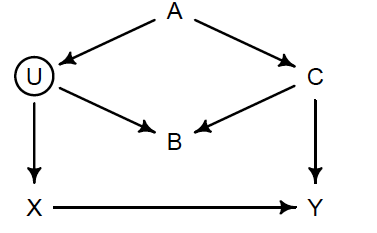



Now imagine adding a variable $V$ that is a cause of $C$ and $Y$.

Now there is our desired causal path $X \rightarrow Y$ and four backdoor paths:
1. $X \leftarrow U \rightarrow B \leftarrow C \rightarrow Y$
2. $X \leftarrow U \rightarrow B \leftarrow C \leftarrow V \rightarrow Y$
3. $X \leftarrow U \leftarrow A \rightarrow C \rightarrow Y$
4. $X \leftarrow U \leftarrow A \rightarrow C \leftarrow V \rightarrow Y$

Since $B$ is a collider, the first two are already closed and no extra variables need to be added to the model. In cases 3 and 4 we just need to block the path at one point, so we could include $A$, $C$ or, in the case 4, $V$ in our model to block the path.




### 6M2

In [186]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats

In [187]:
# Number of examples
N = 50
X = stats.norm.rvs(0, 1, size=N)

In [188]:
Y = (X - X.mean()) + stats.norm.rvs(0, 0.1, size=N)

In [189]:
Z = (Y - Y.mean()) + stats.norm.rvs(0, 0.1, size=N)

In [191]:
def standardize(arr):
    return (arr - arr.mean()) / arr.std()
X_std = standardize(X)
Y_std = standardize(Y)
Z_std = standardize(Z)

In [192]:
with pm.Model() as m1:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = alpha + beta*X_std
    y = pm.Normal('y', mu=mu, sd=sigma, observed=Y_std)

In [193]:
with m1:
    trace = pm.sample(1000, tune=1000)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


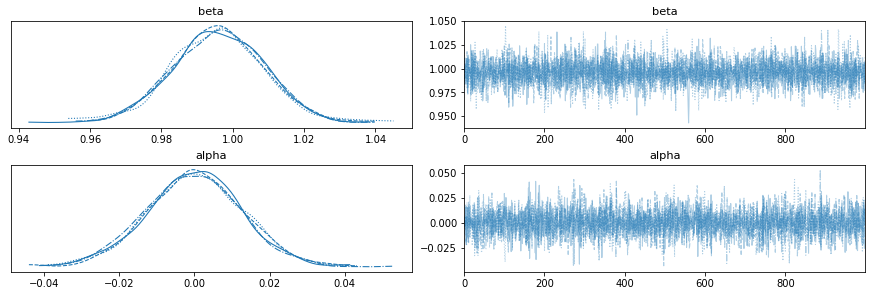

In [194]:
az.plot_trace(trace, var_names=["beta", "alpha"]);

In [195]:
def plot_linear_hdi(a_samples, b_samples, sigma_samples, x_seq):
    obs_samples = []
    for i in range(len(a_samples)):
        mu_sample = a_samples[i] + b_samples[i]*x_seq
        sigma_sample = sigma_samples[i]
        obs_samples.append(np.random.normal(mu_sample, sigma_sample))
    obs_samples = np.array(obs_samples)
    
    # The distribution over observed samples
    az.plot_hdi(x_seq, obs_samples, hdi_prob=0.97)
    
    # The MAP estimate of the relationship
    plt.plot(x_seq, a_samples.mean() + b_samples.mean()*x_seq, color='black')
    
    mu_pred = np.array([a_samples + b_samples*x for x in x_seq]).T
    # The distribution of the mean of mu.
    az.plot_hdi(x_seq, mu_pred, hdi_prob=0.97, color='blue')

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


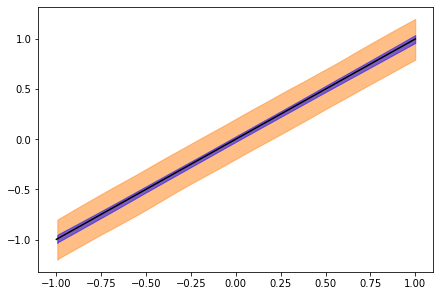

In [196]:
plot_linear_hdi(trace['alpha'], trace['beta'], trace['sigma'], np.linspace(-1, 1, num=30))

In [197]:
with pm.Model() as m2:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = alpha + beta*Y_std
    z = pm.Normal('z', mu=mu, sd=sigma, observed=Z_std)

In [198]:
with m2:
    trace2 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 12 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


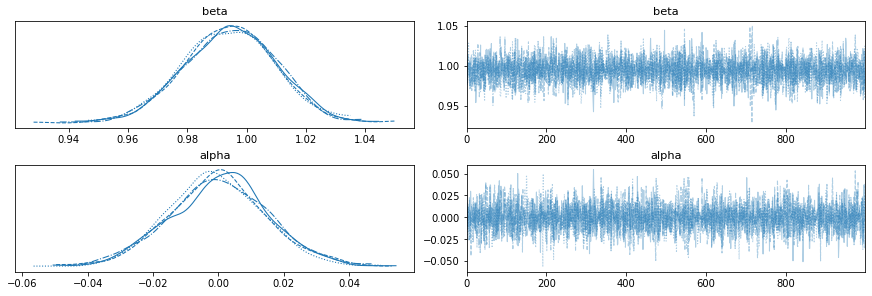

In [199]:
az.plot_trace(trace2, var_names=["beta", "alpha"]);

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


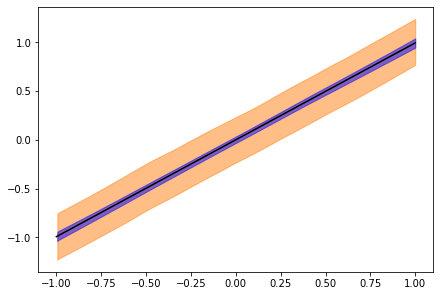

In [200]:
plot_linear_hdi(trace2['alpha'], trace2['beta'], trace2['sigma'], np.linspace(-1, 1, num=30))

In [201]:
with pm.Model() as m3:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    betaX = pm.Normal('betaX', mu=0, sd=1)
    betaY = pm.Normal('betaY', mu=0, sd=1)
    mu = alpha + betaX*X_std + betaY*Y_std
    z = pm.Normal('z', mu=mu, sd=sigma, observed=Z_std)

In [202]:
with m3:
    trace3 = pm.sample(1000, tune=1500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaY, betaX, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9082740571158271, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.896405037796167, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


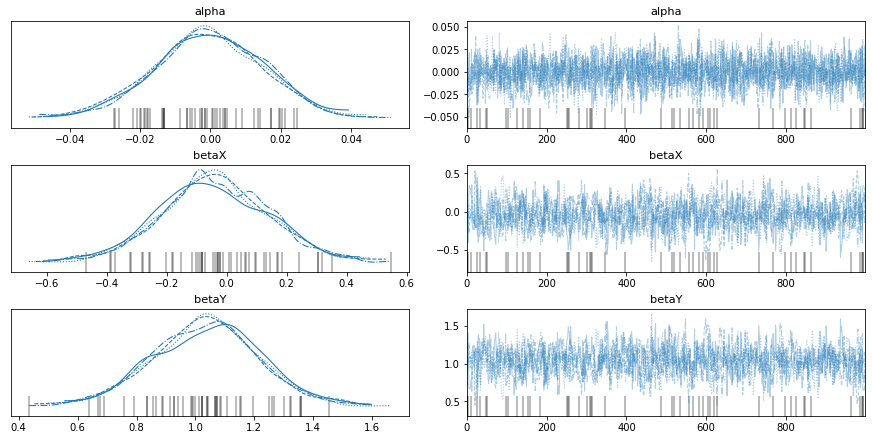

In [203]:
az.plot_trace(trace3, var_names=['alpha', 'betaX', 'betaY']);

We observe that there is a strong statistical association between Y and Z, but not between X and Z. So we don't see multicollinearity, if we take 'multicollinearity' to mean that we see no statistical association between all the predictors and Z. However, we see no association between X and Z. This is because conditioning on Y blocks a path through our causal DAG $X \rightarrow Y \rightarrow Z$. This is therefore a case of post-treatment bias. This sums up the difference with the leg example, which dealt with multicollinearity.

### 6M3

- Top-left: Z
- Top-right: Z
- Bottom-left: None
- Bottom-right: Z

### 6H1

Firstly, I don't believe there is a causal effect of the number of waffle houses on divorce rate. The DAG probably looks something like below, with:
- S: Southernness
- W: Number of waffle houses
- A: Age at marriage
- M: Marriage rate
- D: Divorce rate

In [204]:
from causalgraphicalmodels import CausalGraphicalModel

In [205]:
dag = CausalGraphicalModel(nodes=["A", "M", "S", "W", "D"], edges=[("S", "A"), ("S", "M"), ("A", "M"), ("S", "W"), ("A", "D"), ("M", "D")])

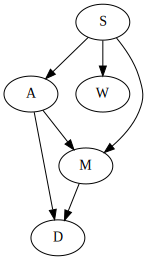

In [206]:
dag.draw()

In such a case, controlling for southernness alone would eliminate any statistical association between $W$ and $D$. However, we might do that and still find some association. In which case there may be some other unknown variable that is a common cause of $W$ and $D$, but we don't know about it and it's not in our dataset.

In [207]:
data = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

In [208]:
data['Divorce_std'] = standardize(data['Divorce'])

In [209]:
data['WaffleHouses_std'] = standardize(data['WaffleHouses'])

In [210]:
data['WaffleHouses_std'].values

array([ 1.45402949, -0.49156715, -0.21796762,  0.13163177, -0.49156715,
       -0.32436744, -0.49156715, -0.44596723, -0.49156715,  1.53002936,
        5.29962285, -0.49156715, -0.49156715, -0.4611672 , -0.2331676 ,
       -0.49156715, -0.40036731,  0.48123117,  0.51163112, -0.49156715,
       -0.32436744, -0.49156715, -0.49156715, -0.49156715,  0.60283096,
        0.10123183, -0.49156715, -0.49156715, -0.49156715, -0.49156715,
       -0.4611672 , -0.49156715,  1.66682912, -0.49156715,  0.48123117,
       -0.24836757, -0.49156715, -0.32436744, -0.49156715,  1.69722907,
       -0.49156715,  1.07403015,  1.01323025, -0.49156715, -0.49156715,
        0.1164318 , -0.49156715, -0.43076726, -0.49156715, -0.49156715])

In [211]:
with pm.Model() as m4:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    mu = alpha[data["South"].values] + beta[data["South"].values]*data['WaffleHouses_std'].values
    d = pm.Normal('d', mu=mu[data["South"].values], sd=sigma, observed=data['Divorce_std'].values)

In [212]:
with m4:
    trace4 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 22 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7112036224679684, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


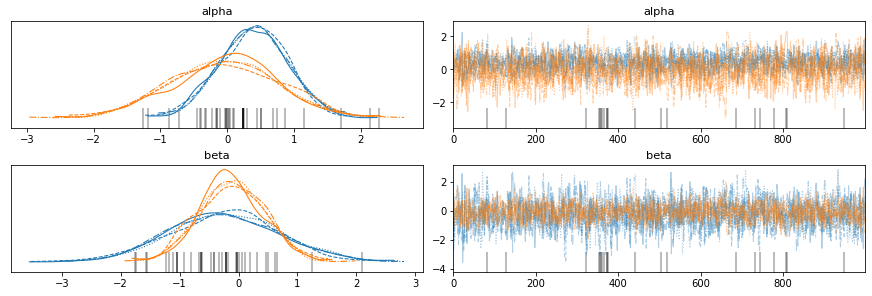

In [213]:
az.plot_trace(trace4, var_names=['alpha', 'beta']);

In [214]:
az.summary(trace4)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.402,0.513,-0.570,1.343,0.014,0.010,1272.0,1691.0,1.0
alpha[1],-0.044,0.807,-1.584,1.417,0.024,0.017,1121.0,1768.0,1.0
beta[0],-0.240,0.943,-1.911,1.641,0.027,0.019,1260.0,1554.0,1.0
beta[1],-0.114,0.558,-1.114,0.946,0.016,0.012,1179.0,1770.0,1.0
sigma,0.965,0.104,0.768,1.150,0.003,0.002,784.0,389.0,1.0


In [215]:
with pm.Model() as m5:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = alpha + beta*data['WaffleHouses_std'].values
    d = pm.Normal('d', mu=mu, sd=sigma, observed=data['Divorce_std'].values)

In [216]:
with m5:
    trace5 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 17 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

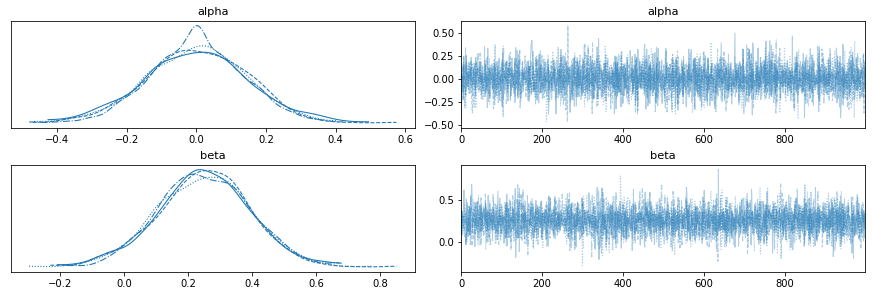

In [217]:
az.plot_trace(trace5, var_names=['alpha', 'beta'])

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'beta'}>

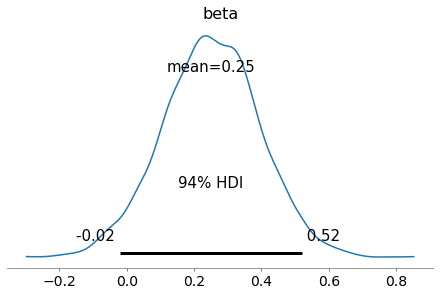

In [218]:
az.plot_posterior(trace5, var_names=['beta'])

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>], dtype=object)

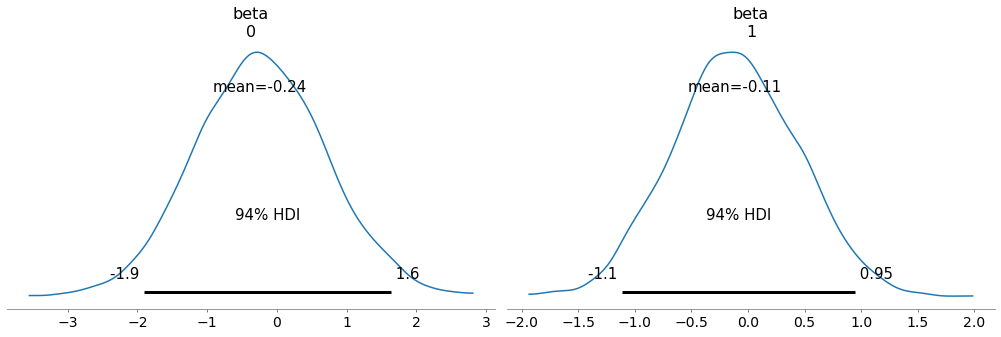

In [219]:
az.plot_posterior(trace4, var_names=['beta'])

Once you control for southernness, the positive association between waffle houses and divorce disappears.

### 6H2

First, let's consider the conditional independencies in the DAG:

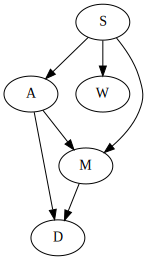

In [220]:
dag.draw()

They are:
1. $D \perp W | S$
2. $M \perp W | S$
3. $A \perp W | S$
4. $S \perp D | A, M$

We can make models for each of these where we condition on $S$ and confirm that there isn't a relationship. We have already considered the first one. So let's consider the others:

#### 2. $M \perp W | S$

In [221]:
data['Marriage_std'] = standardize(data['Marriage'])

In [222]:
with pm.Model() as m6:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = alpha + beta*data['WaffleHouses_std'].values
    m = pm.Normal('m', mu=mu, sd=sigma, observed=data['Marriage_std'].values)

In [223]:
with m6:
    trace6 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 13 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

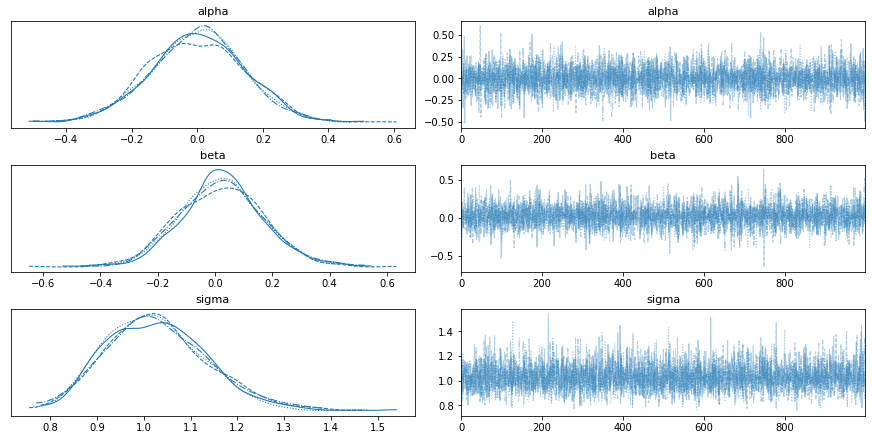

In [224]:
az.plot_trace(trace6)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'beta'}>

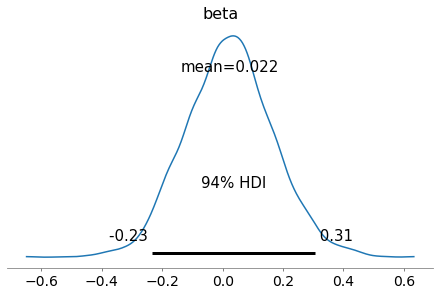

In [226]:
az.plot_posterior(trace6, var_names=['beta'])

In [227]:
with pm.Model() as m7:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    mu = alpha[data["South"].values] + beta[data["South"].values]*data['WaffleHouses_std'].values
    m = pm.Normal('m', mu=mu[data["South"].values], sd=sigma, observed=data['Marriage_std'].values)

In [228]:
with m7:
    trace7 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8888697174491388, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

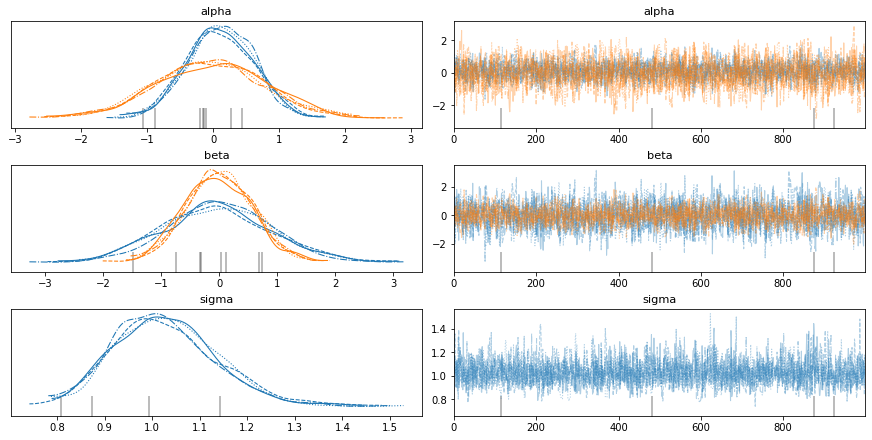

In [229]:
az.plot_trace(trace7)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>], dtype=object)

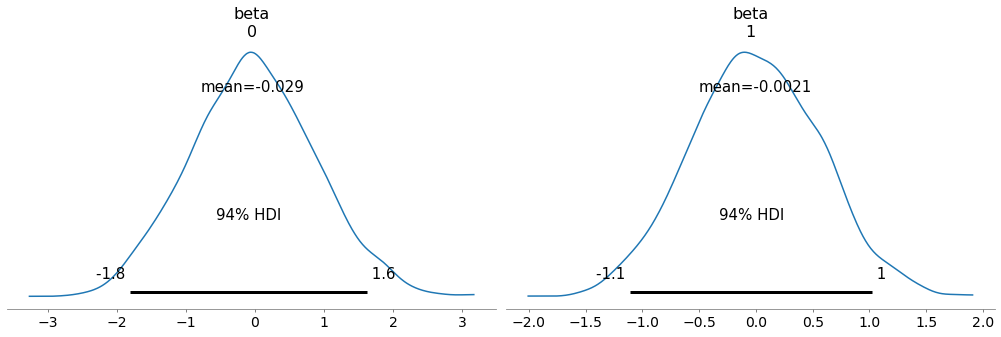

In [230]:
az.plot_posterior(trace7, var_names=['beta'])

#### 3. $A \perp W | S$

In [231]:
data['MedianAgeMarriage_std'] = standardize(data['MedianAgeMarriage'])

In [232]:
data['WaffleHouses_std'] = standardize(data['WaffleHouses'])

In [234]:
with pm.Model() as m8:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = alpha + beta*data['WaffleHouses_std'].values
    m = pm.Normal('m', mu=mu, sd=sigma, observed=data['MedianAgeMarriage_std'].values)

In [235]:
with m8:
    trace8 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 13 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

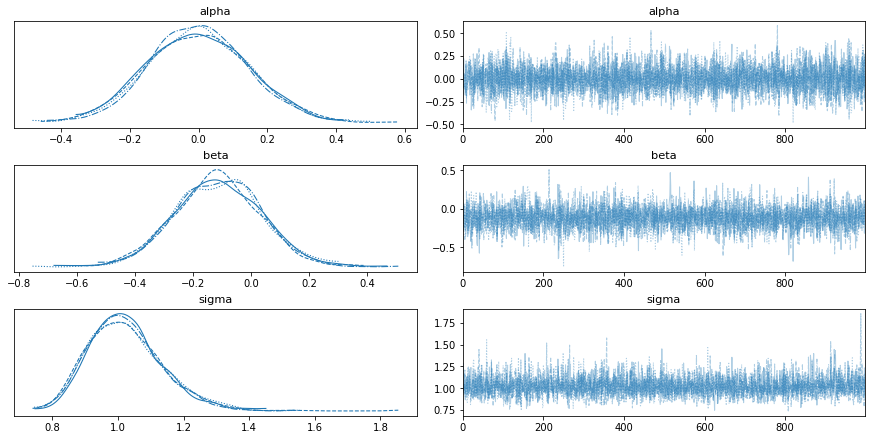

In [236]:
az.plot_trace(trace8)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'beta'}>

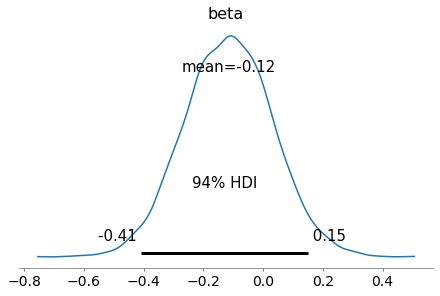

In [237]:
az.plot_posterior(trace8, var_names=['beta'])

There's a slight negative association between WaffleHouses and age at marriage.

In [239]:
with pm.Model() as m9:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    mu = alpha[data["South"].values] + beta[data["South"].values]*data['WaffleHouses_std'].values
    m = pm.Normal('m', mu=mu[data["South"].values], sd=sigma, observed=data['MedianAgeMarriage_std'].values)

In [240]:
with m9:
    trace9 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

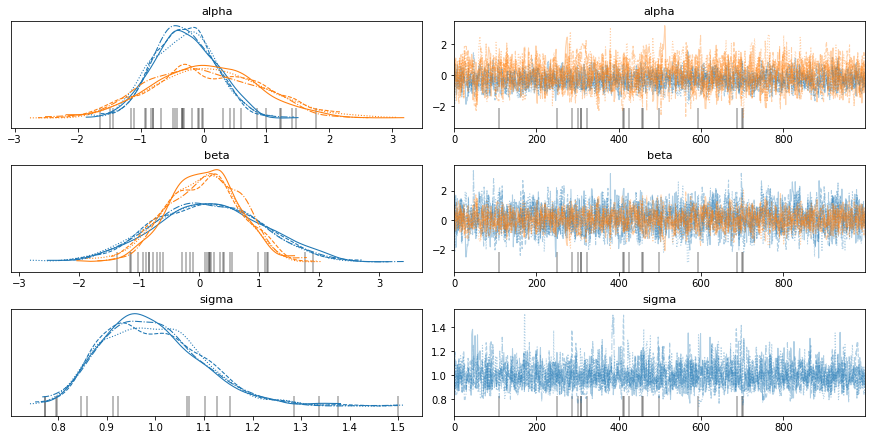

In [241]:
az.plot_trace(trace9)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>], dtype=object)

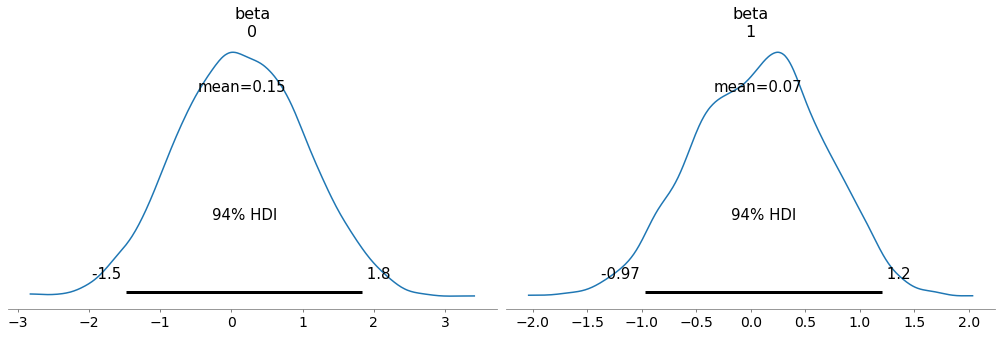

In [243]:
az.plot_posterior(trace9, var_names=['beta'])

The negative association is reduced.

#### 4. $S \perp D | A, M$

In [248]:
with pm.Model() as m10:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    mu = pm.Normal('mu', mu=0, sd=1, shape=2)
    m = pm.Normal('m', mu=mu[data['South'].values], sd=sigma, observed=data['Divorce_std'].values)

In [245]:
data['Divorce_std'] = standardize(data['Divorce'])

In [249]:
with m10:
    trace10 = pm.sample(1000, tune=1500)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 15 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

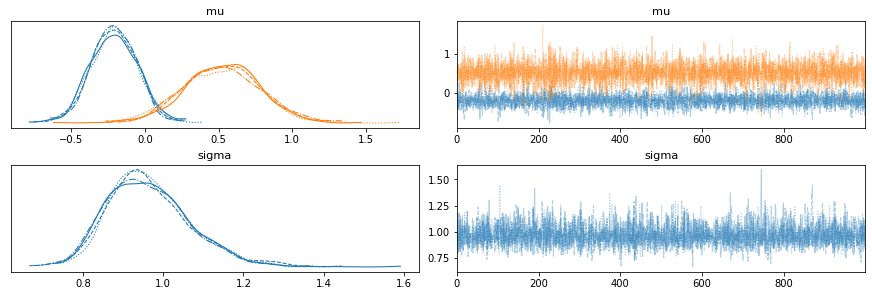

In [250]:
az.plot_trace(trace10)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'mu\n0'}>,
       <AxesSubplot:title={'center':'mu\n1'}>], dtype=object)

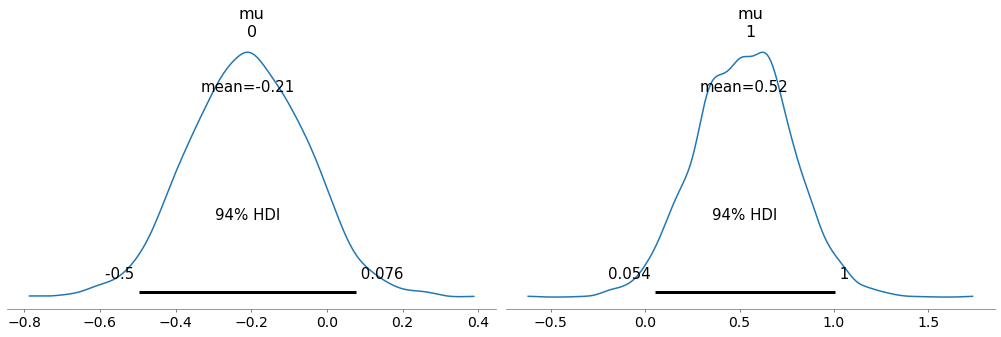

In [258]:
az.plot_posterior(trace10, var_names=['mu'])

Here we see that southern states have clearly a higher divorce rate than non-southern states.

Now let's see what happens when we control for median age at marriage and the marriage rate.

In [252]:
with pm.Model() as m11:
    sigma = pm.Lognormal('sigma', mu=1, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=2)
    betaA = pm.Normal('betaA', mu=0, sd=1, shape=2)
    betaM = pm.Normal('betaM', mu=0, sd=1, shape=2)
    mu = alpha[data["South"].values] + betaA[data["South"].values]*data['MedianAgeMarriage_std'].values + betaM[data["South"].values]*data['Marriage_std'].values
    d = pm.Normal('d', mu=mu[data["South"].values], sd=sigma, observed=data['Divorce_std'].values)

In [253]:
with m11:
    trace11 = pm.sample(1000, tune=1000)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaM, betaA, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'betaA'}>,
        <AxesSubplot:title={'center':'betaA'}>],
       [<AxesSubplot:title={'center':'betaM'}>,
        <AxesSubplot:title={'center':'betaM'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

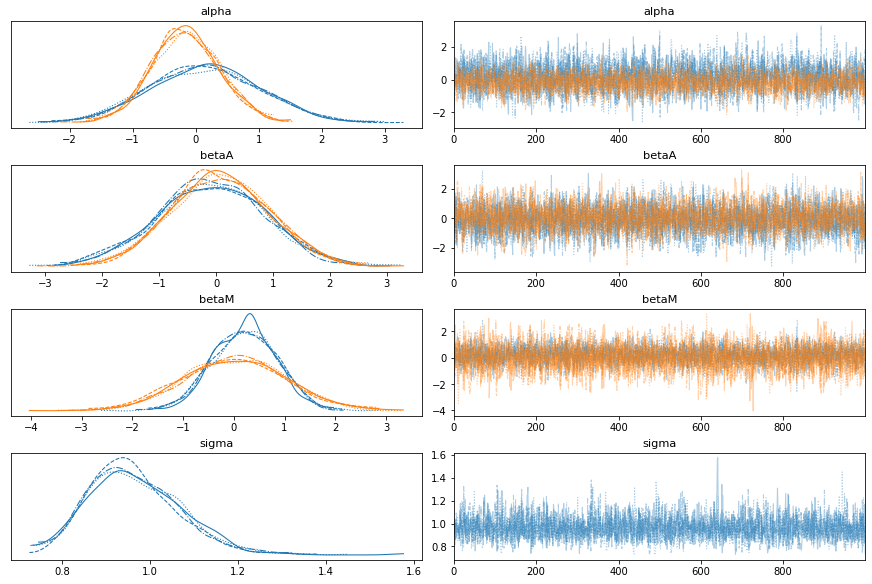

In [254]:
az.plot_trace(trace11)

/Users/oadams/code/oadams.github.io/statistical_rethinking_solutions/venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'betaA\n0'}>,
       <AxesSubplot:title={'center':'betaA\n1'}>,
       <AxesSubplot:title={'center':'betaM\n0'}>,
       <AxesSubplot:title={'center':'betaM\n1'}>], dtype=object)

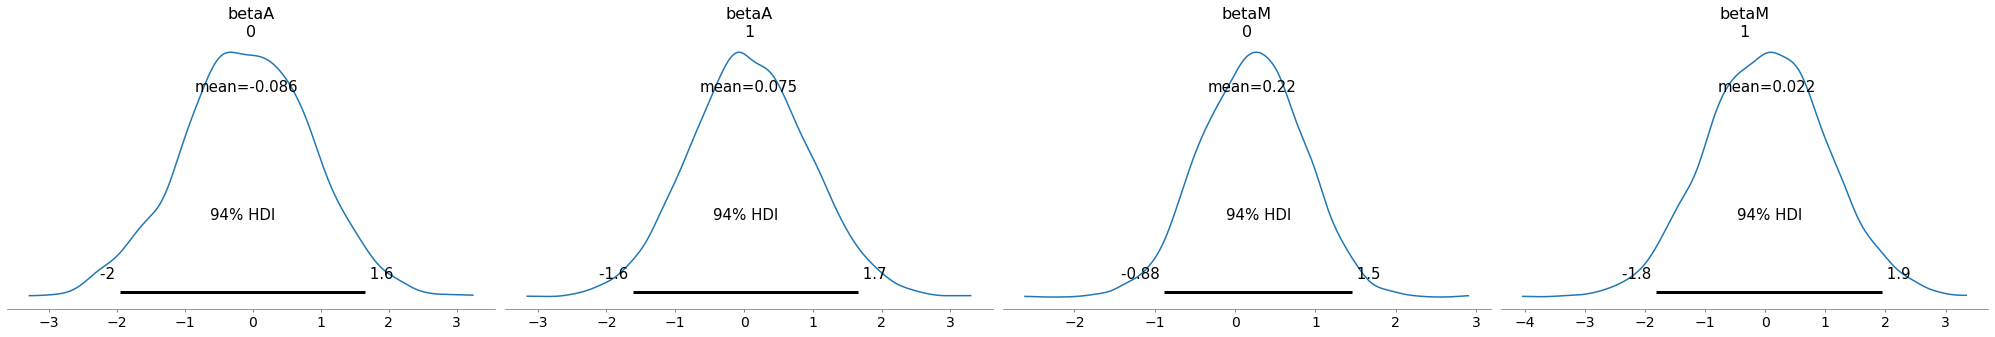

In [257]:
az.plot_posterior(trace11, var_names=['betaA', 'betaM'])

Clearly we see that the distributions look pretty similar regardless of southernness.

### 6H3